In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import networkx as nx

from matching.neuralmatch import utils
from matching.neuralmatch.test import validate
from matching.neuralmatch.args import Args, load_args
from matching.neuralmatch.model import build_model
from matching.neuralmatch.dataset import get_dataset, gen_batch, gen_data_loaders, batch_nx_graphs

In [2]:
print(f"device is {utils.get_device()}")
args = load_args( Args().model_args_path )
args.test = True
model = build_model( args )
dataset = get_dataset(node_size=100)
results = validate( args, model, dataset )
acc, prec, recall, auroc, avg_prec, tn, fp, fn, tp = results
print( f"A: {acc:.4f} / P: {prec:.4f} / R: {recall:.4f}. AR: {auroc:.4f} / AP: {avg_prec:.4f}" )
print( f"TN: {tn} / FP: {fp} / FN: {fn} / TP: {tp}" )

device is cpu
A: 0.7661 / P: 0.6934 / R: 0.9541. AR: 0.8353 / AP: 0.7624
TN: 592 / FP: 432 / FN: 47 / TP: 977


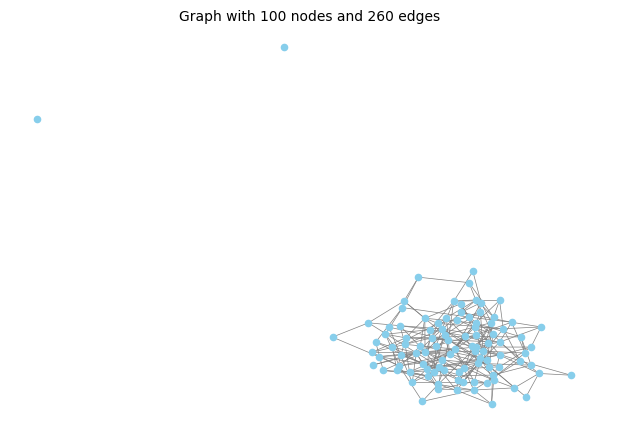

In [3]:
dataset_example = dataset[1][0]
utils.plot_graph(dataset_example)

In [4]:
test_loaders = gen_data_loaders(args.val_size, args.batch_size)
example_batch = None
example_batch_graphs = None
for batch_target, batch_neg_target, batch_neg_query in zip(*test_loaders):
    example_batch = gen_batch( dataset, batch_target, batch_neg_target, batch_neg_query, True )
    example_batch_graphs = gen_batch( dataset, batch_target, batch_neg_target, batch_neg_query, True, batched=False )
    break
   
pos_target_graph, pos_query_graph, neg_target_graph, neg_query_graph = example_batch_graphs 
pos_target, pos_query, neg_target, neg_query = example_batch

test_labels = torch.tensor([1]*(pos_target.num_graphs if neg_target else 0) + [0]*neg_target.num_graphs).to(utils.get_device())
model.eval()
with torch.no_grad():
    
    emb_pos_target, emb_pos_query = model.emb_model(pos_target), model.emb_model(pos_query)
    emb_neg_target, emb_neg_query = model.emb_model(neg_target), model.emb_model(neg_query)
    
    emb_targets = torch.cat((emb_pos_target, emb_neg_target), dim=0)
    emb_queries = torch.cat((emb_pos_query, emb_neg_query), dim=0)
                
    pred = model(emb_targets, emb_queries)
    raw_pred = model.predict(pred)
    
    pred = model.clf_model(raw_pred.unsqueeze(1)).argmax(dim=-1)
    raw_pred *= -1
    
print(pred)
print(raw_pred)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1])
tensor([-0.0000e+00, -3.9487e-03, -3.9791e-03, -4.0515e-03, -4.5835e-03,
        -3.6988e-03, -1.8344e-02, -0.0000e+00, -0.0000e+00, -2.8366e-02,
        -0.0000e+00, -6.8949e-03, -1.5625e-03, -0.0000e+00, -0.0000e+00,
        -3.4687e-02, -0.0000e+00, -3.5878e-04, -0.0000e+00, -5.7903e-03,
        -1.5263e-04, -0.0000e+00, -1.2828e-03, -1.1571e-01, -8.2391e-03,
        -2.6170e-02, -2.2395e-02, -2.8704e-04, -1.5928e-02, -0.0000e+00,
        -0.0000e+00, -2.4155e-04, -3.9294e-02, -5.3476e-01, -8.1446e-01,
        -3.1603e+00, -6.6274e+00, -6.3814e-02, -4.6519e-02, -9.7210e+00,
        -5.8756e+01, -3.3446e-02, -9.2714e-02, -1.4172e-01, -3.8670e+00,
        -8.5682e-01, -1.5403e+00, -2.2395e-02, -2.4623e-01, -1.0652e+01,
        -1.2919e+01, -1.2878e+01, -2.1970e+00, -2.710

In [5]:
test_idx = 0

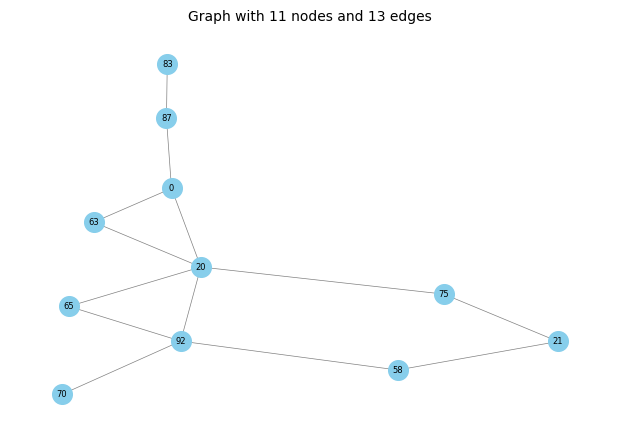

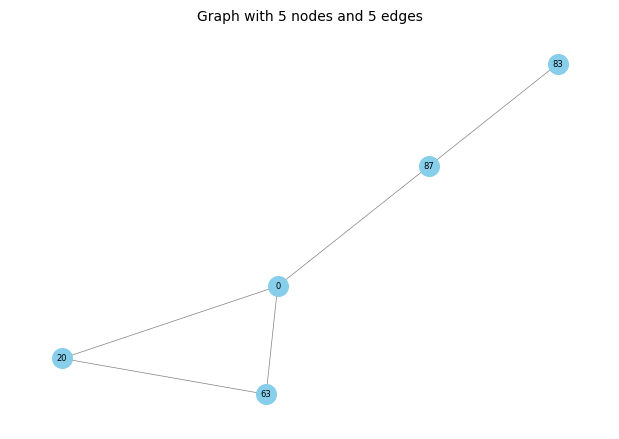

Is query is subgraph - model: True / actual  True


In [6]:
utils.plot_graph(pos_target_graph[test_idx], with_label=True)
utils.plot_graph(pos_query_graph[test_idx], with_label=True)
print(f"Is query is subgraph - model: {pred[test_idx] == True} / actual  {test_labels[test_idx] == True}")

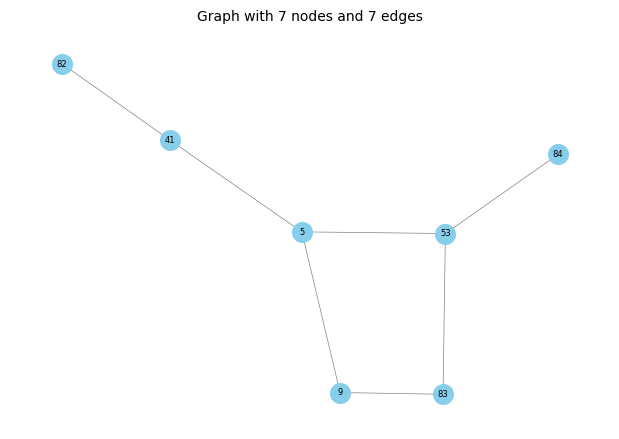

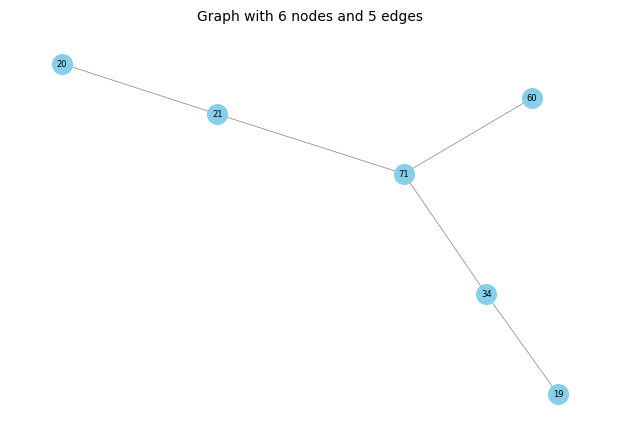

Is query is subgraph - model: True / actual: False


In [7]:
utils.plot_graph(neg_target_graph[test_idx], with_label=True)
utils.plot_graph(neg_query_graph[test_idx], with_label=True)
print(f"Is query is subgraph - model: {pred[len(pos_target_graph) + test_idx] == True} / actual: {test_labels[len(pos_target_graph) + test_idx] == True}")

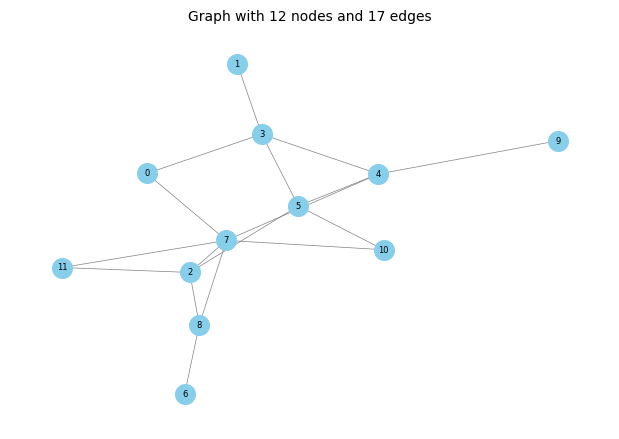

In [15]:
target = nx.gnp_random_graph(12, 0.25)
"""
target = nx.Graph()
target.add_edge(1, 2)
target.add_edge(1, 3)
target.add_edge(1, 5)
target.add_edge(2, 3)
target.add_edge(3, 4)
target.add_edge(4, 5)
target.add_edge(2, 6)
"""
utils.plot_graph(target, with_label=True)

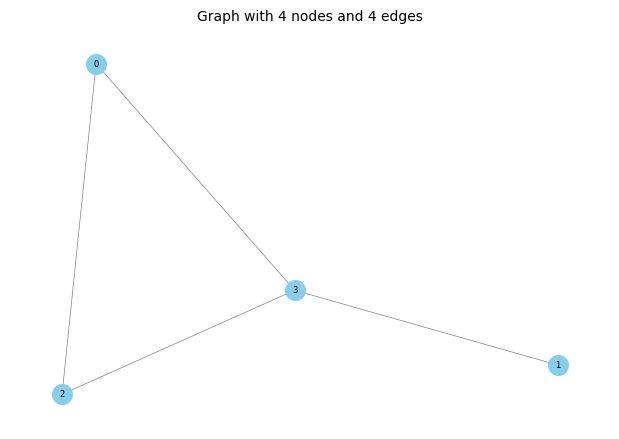

In [21]:
query = nx.gnp_random_graph(4, 0.25)
"""
query = nx.Graph()
query.add_edge(1, 2)
query.add_edge(2, 3)
query.add_edge(3, 1)
query.add_edge(3, 4)
"""
utils.plot_graph(query, with_label=True)

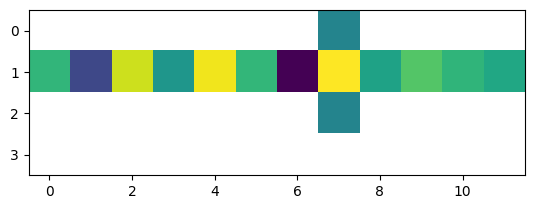

In [22]:
mat = np.zeros((len(query), len(target)))
for i, u in enumerate(query.nodes):
    for j, v in enumerate(target.nodes):
        batch = batch_nx_graphs([query, target], anchors=[u, v])
        embs = model.emb_model(batch)
        pred = model(embs[1].unsqueeze(0), embs[0].unsqueeze(0))
        raw_pred = model.predict(pred)
        raw_pred = torch.log(raw_pred)
        mat[i][j] = raw_pred.item()
        
plt.imshow(mat, interpolation="nearest")